In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import os
import pymannkendall as mk
import matplotlib.pyplot as plt
import seaborn as sns

home = "/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling"

In [2]:
# subset to anomalies
# Group by NHDPlusID, Var, and Season
# sort by year
# calculate sens slope and mann kendall trend test 

def clim_trend(Value, Year):
    sorted_values = [x for _, x in sorted(zip(Year, Value))]
    mks = mk.original_test(sorted_values)
    pvalue = mks[2]
    slope = mks[7]
    pd_list = [{'slope':slope, 'pvalue':pvalue}]
    return pd.DataFrame(pd_list)

def summarize_climate_trend(VAR):
    df = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", VAR))
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df['Type'] == 'anomalies']
    df_trends = df.groupby(['NHDPlusID', 'Season']).apply(lambda x: clim_trend(x.Value, x.Year))
    df_trends = df_trends.reset_index()
    df_trends.to_csv(os.path.join(home, "Data", "Climate", "Summary", 'gs_trends_' + VAR))
    return 

In [ ]:
prcp_trends = summarize_climate_trend("gs_prcp.csv")
tmax_trends = summarize_climate_trend("gs_tmax.csv")
tmin_trends = summarize_climate_trend("gs_tmin.csv")
vp_trends = summarize_climate_trend("gs_vp.csv")
vpd_trends = summarize_climate_trend("gs_vpd.csv")
par_trends = summarize_climate_trend("gs_par.csv")

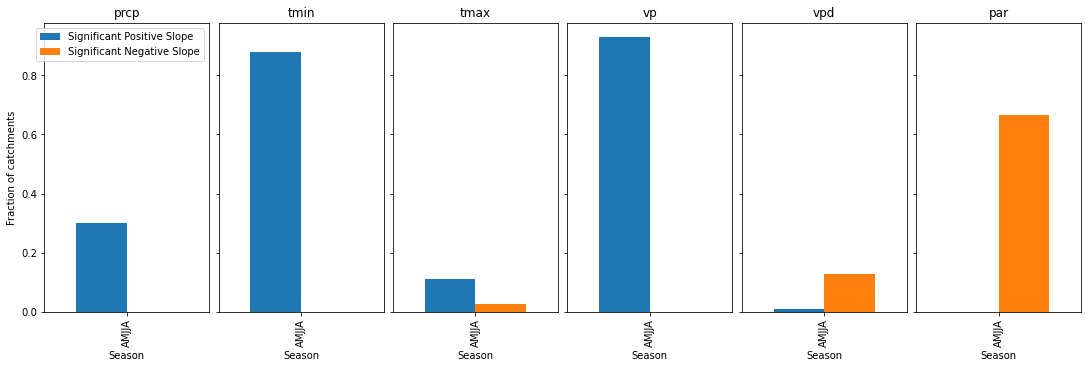

In [22]:
# summarize the climate trend extent and make a nice table and plot
def summarize_trends(slope, pval):
    pval = pval.tolist()
    slope = slope.tolist()
    keep = [i for i in range(len(pval)) if pval[i] <= 0.05]
    keep_slopes = pd.DataFrame({'SigSlope':[slope[x] for x in keep]})
    pos_slopes = keep_slopes[keep_slopes['SigSlope'] > 0].shape[0]/len(slope)
    neg_slopes = keep_slopes[keep_slopes['SigSlope'] <= 0].shape[0]/len(slope)
    dix = [{"pos_slope_pct":round(pos_slopes, 3), "neg_slope_pct":round(neg_slopes, 3)}]
    return pd.DataFrame(dix)

def summarize_climate_trends(VAR_LIST): 
    results = []
    for VAR in VAR_LIST:
        trend = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'gs_trends_gs_' + VAR + ".csv"))
        summary = trend.groupby(['Season']).apply(lambda x: summarize_trends(x.slope, x.pvalue)).reset_index()
        summary['var'] = [VAR]*summary.shape[0]
        summary = summary.drop(['level_1'], axis=1)
        results.append(summary)

    result = pd.concat(results)
    return result   

vars = ['prcp','tmin', 'tmax', 'vp', 'vpd','par']
trends = summarize_climate_trends(vars)

# plot the brekdown of isgnficant trends by season 
fig, axes = plt.subplots(nrows=1,ncols=6, figsize=(15,5), constrained_layout=True, sharex=True, sharey=True)
trends = trends.rename(columns={"Season":"Season", "pos_slope_pct":"Significant Positive Slope", "neg_slope_pct":"Significant Negative Slope", "var":"var"})
for i, ax in zip(range(len(vars)), axes.flatten()):
    sub = trends[trends['var'] == vars[i]]
    if i == 0:
        sub.plot(x='Season', kind='bar', stacked=False, title=vars[i], ax=ax, width=0.8, legend=True, ylabel="Fraction of catchments")
    else:
        sub.plot(x='Season', kind='bar', stacked=False, title=vars[i], ax=ax, width=0.8, legend=False)


In [23]:
trends

,Season,Significant Positive Slope,Significant Negative Slope,var
0,AMJJA,0.301,0.000,prcp
0,AMJJA,0.878,0.000,tmin
0,AMJJA,0.112,0.025,tmax
0,AMJJA,0.931,0.000,vp
0,AMJJA,0.008,0.128,vpd
0,AMJJA,0.000,0.665,par


In [27]:
# make a table of the summmary statistics for climate trend and the fraction of catchments with a significant trend 
def summary_stats(var):
    trend_dt = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'gs_trends_gs_' + var + ".csv"))
    trend_dt = trend_dt[trend_dt["Season"] == "AMJJA"]
    trend_dt = trend_dt[trend_dt["pvalue"] <= 0.05]
    slope = trend_dt.slope
    fq = np.quantile(slope, 0.25)
    med = np.quantile(slope, 0.5)
    men = np.mean(slope)
    tq = np.quantile(slope, 0.75)
    sd = np.std(slope)
    frac = len(slope)/30044
    row = {'Pred':var,'FracSig':frac, "FQ":fq, "Median":med, "Mean":men, "TQ":tq, "SD":sd}
    return row

vars = ['tmin', 'tmax', 'vp', 'vpd','prcp', 'par']
rows = []
for var in vars:
    rows.append(summary_stats(var))

trend_summary = pd.DataFrame(rows)
trend_summary
trend_summary.to_csv(os.path.join(home, "Data","climate_trend_summary_stats.csv"))


In [5]:
# compare with gridmet just to double check this resul t
def clim_trend(Value, Year):
    sorted_values = [x for _, x in sorted(zip(Year, Value))]
    mks = mk.original_test(sorted_values)
    pvalue = mks[2]
    slope = mks[7]
    pd_list = [{'slope':slope, 'pvalue':pvalue}]
    return pd.DataFrame(pd_list)

def summarize_climate_trend(VAR):
    df = pd.read_csv(os.path.join(home, "Data", "Climate", "gridmet","Summary", VAR))
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df['Type'] == 'anomalies']
    df_trends = df.groupby(['NHDPlusID', 'Season']).apply(lambda x: clim_trend(x.Value, x.Year))
    df_trends = df_trends.reset_index()
    df_trends.to_csv(os.path.join(home, "Data", "Climate", "gridmet","Summary", 'gs_trends_' + VAR))
    return 

In [6]:
summarize_climate_trend("gs_vpd.csv")

In [21]:
gridmet_vpd_trend = pd.read_csv(os.path.join(home, "Data", "Climate", "gridmet","Summary", "gs_trends_gs_vpd.csv"))
summary = gridmet_vpd_trend.groupby(['Season']).apply(lambda x: summarize_trends(x.slope, x.pvalue)).reset_index()
summary['var'] = ['VPD']*summary.shape[0]
summary = summary.drop(['level_1'], axis=1)
summary

,Season,pos_slope_pct,neg_slope_pct,var
0,AMJJA,0.016,0.0,VPD


In [24]:
# Gridmet has 1.6% of catchments with a significant positive slope 
# Daymet shows 0.8% of catchments with a significant positive slope and 12% with a significant negative slope 
# Daymet shows 66.5% of catchments with a significant negative slope in photosynthetically active radiation (PAR) ---- i think this could be related to the increase in precipitation 

# So I'm going to stick with daymet (that i calculated myself) because it's pretty similar to gridmet (calculated by the gridmet team) and is higher resolution 